In [1]:
# Standard libraries
import os
import os.path as op
import datetime
from pathlib import Path
import sys

# Data manipulation libraries
import numpy as np
import pandas as pd
import xarray as xr

# Data analysis libraries
import scipy.stats as stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

from urllib.request import urlretrieve #used for downloading files

# Miscellaneous
from myst_nb import glue  # used for figure numbering when exporting to LaTeX

sys.path.append("../../../functions")
from data_downloaders import download_oni_index


In [2]:
data_dir = Path('../../../data')
path_figs = "../../../matrix_cc/figures"
data_dir = Path(data_dir,'sea_level')

#CHANGE THIS TO YOUR PATH!!
output_dir = Path('/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/data/')  # EDIT THIS TO YOUR PATH

# Create the output directory if it does not exist
output_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)

In [3]:
uhslc_id = 7
# download the hourly data
fname = f'h{uhslc_id:03}.nc' # h for hourly, d for daily

url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/" 

path = os.path.join(data_dir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path) 

rsl = xr.open_dataset(data_dir / fname)

# remove the trailing zero from record_id. This zero is added to the record_id to make it unique if the station has multiple entries
rsl['record_id'] =(rsl['record_id']/10).astype(int)
rsl

<xarray.Dataset> Size: 6MB
Dimensions:               (record_id: 1, time: 486849)
Coordinates:
  * time                  (time) datetime64[ns] 4MB 1969-05-18T15:00:00 ... 2...
  * record_id             (record_id) int64 8B 7
Data variables:
    sea_level             (record_id, time) float32 2MB ...
    lat                   (record_id) float32 4B ...
    lon                   (record_id) float32 4B ...
    station_name          (record_id) |S7 7B ...
    station_country       (record_id) |S5 5B ...
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-01-27T14:35:24Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [4]:
station = rsl['station_name'].values[0].decode('utf-8')
country = rsl['station_country'].values[0].decode('utf-8')
startDateTime = str(rsl.time.values[0])[:10]
endDateTime = str(rsl.time.values[-1])[:10]
station_name = station + ', ' + country

glue("station",station,display=False)
glue("country",country, display=False)
glue("startDateTime",startDateTime, display=False)
glue("endDateTime",endDateTime, display=False)


In [5]:
def get_MHHW_uhslc_datums(id, datumname): 
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_mm_GMT.csv'
    datumtable = pd.read_csv(url)
    datum = datumtable[datumtable['Name'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    return datum, datumtable

In [6]:
# extract the given datum from the dataframe
datumname = 'MHHW'

datum, datumtable = get_MHHW_uhslc_datums(uhslc_id, datumname)

rsl['datum'] = datum # already in mm
rsl['sea_level_mhhw'] = rsl['sea_level'] - rsl['datum']

# assign units to datum and sea level
rsl['datum'].attrs['units'] = 'mm'
rsl['sea_level_mhhw'].attrs['units'] = 'mm'

glue("datum", datum, display=False)
glue("datumname", datumname, display=False)

datumtable



,Name,Value,Description
0,Status,27-Nov-2024,Processing Date
1,Epoch,01-Jan-1983 to 31-Dec-2001,Tidal Datum Analysis Period
2,MHHW,2162,Mean Higher-High Water (mm)
3,MHW,2087,Mean High Water (mm)
4,MTL,1530,Mean Tide Level (mm)
5,MSL,1532,Mean Sea Level (mm)
6,DTL,1458,Mean Diurnal Tide Level (mm)
7,MLW,974,Mean Low Water (mm)
8,MLLW,753,Mean Lower-Low Water (mm)
9,STND,0,Station Datum (mm)


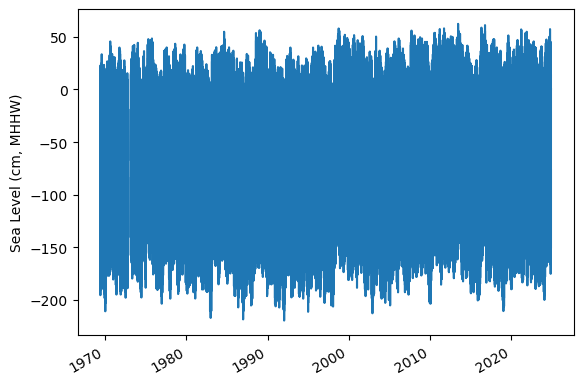

In [7]:
fig, ax = plt.subplots(sharex=True)
fig.autofmt_xdate()
ax.plot(rsl.time.values,rsl.sea_level_mhhw.T.values/10)

ax.set_ylabel(f'Sea Level (cm, {datumname})') #divide by 10 to convert to cm

glue("TS_full_fig",fig,display=False)


In [8]:
#get epoch start time from the epoch in the datumtable
epoch_times = datumtable[datumtable['Name'] == 'Epoch']['Value'].values[0]

#parse epoch times into start time
epoch_start = epoch_times.split(' ')[0]
epoch_start = datetime.datetime.strptime(epoch_start, '%d-%b-%Y')

# and for now, end time the processind end time
epoch_end = epoch_times.split(' ')[2]
epoch_end = datetime.datetime.strptime(epoch_end, '%d-%b-%Y')

# last date is rsl['last_rq_date'].values
data_end = rsl['time'].values[-1]
data_end = pd.to_datetime(data_end)

# start the data at year before epoch_start year on May 1st
data_start = pd.Timestamp(year=epoch_start.year-1, month=5, day=1)
data_start = pd.to_datetime(data_start)

# end the data at April 30th of the year of the last data request
data_end = pd.Timestamp(year=data_end.year, month=4, day=30)
data_end = pd.to_datetime(data_end)

hourly_data = rsl.sel(dict(time=slice(data_start, data_end)))
hourly_data

glue("startDataDateTime",data_start.strftime('%Y-%m-%d'), display=False)
glue("endDataDateTime",data_end.strftime('%Y-%m-%d'), display=False)
glue("startEpochDateTime",epoch_start.strftime('%Y-%m-%d'), display=False)
glue("endEpochDateTime",epoch_end.strftime('%Y-%m-%d'), display=False)


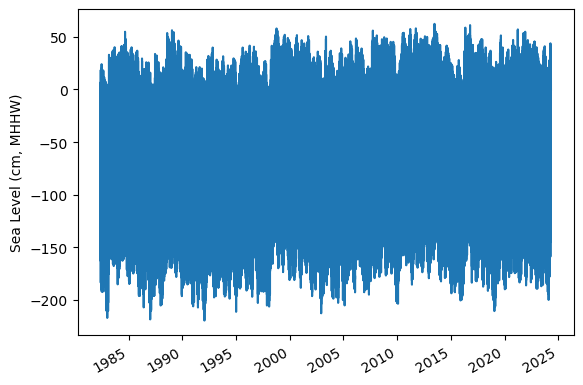

In [9]:
fig, ax = plt.subplots(sharex=True)
fig.autofmt_xdate()
ax.plot(hourly_data.time.values,hourly_data.sea_level_mhhw.T.values/10) #divide by 10 to convert to cm


ax.set_ylabel(f'Sea Level (cm, {datumname})')

glue("TS_epoch_fig",fig,display=False)


In [10]:
threshold = 30 # in cm
glue("threshold",threshold,display=False)


In [11]:
# Resample the hourly data to daily maximum sea level
SL_daily_max = hourly_data.resample(time='D').max()
static_vars = hourly_data[['station_name', 'station_country','station_country_code', 'datum','lat', 'lon','uhslc_id','gloss_id','ssc_id','last_rq_date']] 

SL_daily_max = SL_daily_max.assign(static_vars)
SL_daily_max

<xarray.Dataset> Size: 307kB
Dimensions:               (time: 15341, record_id: 1)
Coordinates:
  * record_id             (record_id) int64 8B 7
  * time                  (time) datetime64[ns] 123kB 1982-05-01 ... 2024-04-30
Data variables:
    sea_level             (time, record_id) float32 61kB 1.881e+03 ... 2.161e+03
    lat                   (record_id) float32 4B 7.33
    lon                   (record_id) float32 4B 134.5
    station_name          (record_id) |S7 7B b'Malakal'
    station_country       (record_id) |S5 5B b'Palau'
    station_country_code  (record_id) float32 4B 585.0
    uhslc_id              (record_id) int16 2B 7
    gloss_id              (record_id) float32 4B 120.0
    ssc_id                (record_id) |S4 4B b'mala'
    last_rq_date          (record_id) datetime64[ns] 8B 2018-12-31T22:59:59.9...
    datum                 float64 8B 2.162e+03
    sea_level_mhhw        (time, record_id) float64 123kB -281.0 -163.0 ... -1.0
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-01-27T14:35:24Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

Text(0.5, 1.0, 'Sea Level Daily Maximum Time Series')

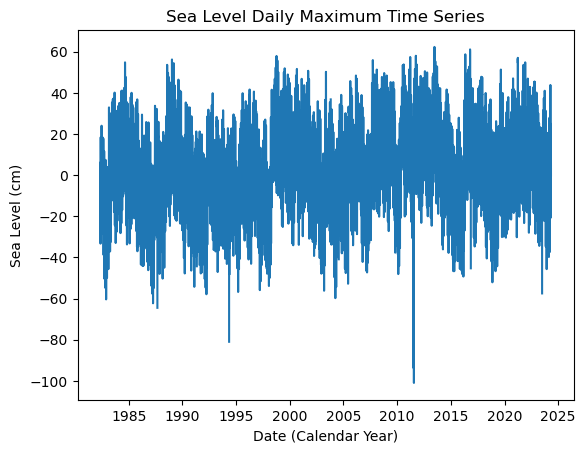

In [12]:
# make a new figure that is 15 x 5
fig, ax = plt.subplots(sharex=True)
plt.plot(SL_daily_max.time.values, SL_daily_max.sea_level_mhhw.values/10)
plt.xlabel('Date (Calendar Year)')
plt.ylabel('Sea Level (cm)')
plt.title('Sea Level Daily Maximum Time Series')

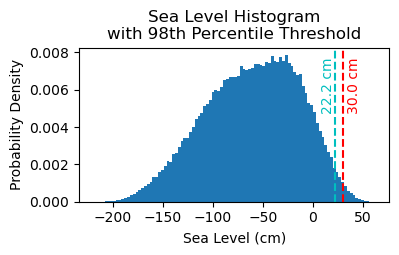

In [13]:
# Make a pdf of the data with 95th percentile threshold

sea_level_data_cm = hourly_data['sea_level_mhhw'].values/10 # convert to cm
#remove nans
sea_level_data_cm = sea_level_data_cm[~np.isnan(sea_level_data_cm)]

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(sea_level_data_cm, bins=100, density=True, label='Sea Level Data')

#get 95th percentile
threshold98 = np.percentile(sea_level_data_cm, 98)

ax.axvline(threshold, color='r', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold))
ax.axvline(threshold98, color='c', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold98))

ax.set_xlabel('Sea Level (cm)')
ax.set_ylabel('Probability Density')
# make the title two lines
ax.set_title('Sea Level Histogram\nwith 98th Percentile Threshold')

# add label to dashed line
# get value of middle of y-axis for label placement
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
y_middle = ymin + 0.75*yrange

ax.text(threshold+4, y_middle, '{:.1f} cm'.format(threshold), rotation=90, va='center', ha='left', color='r')
ax.text(threshold98, y_middle, '{:.1f} cm'.format(threshold98), rotation=90, va='center', ha='right', color='c')

glue("histogram_fig", fig, display=False)

In [14]:
# Find all days where sea level exceeds the threshold
flood_days_df = SL_daily_max.to_dataframe().reset_index()

flood_days_df['year_storm'] = flood_days_df['time'].dt.year
flood_days_df.loc[flood_days_df['time'].dt.month > 4, 'year_storm'] = flood_days_df['time'].dt.year + 1

#filter flood hours
flood_days_df = flood_days_df[flood_days_df['sea_level_mhhw'] > threshold*10]

flood_days_per_year = flood_days_df.groupby('year_storm').size().reset_index(name='flood_days_count')

all_years = pd.DataFrame({'year_storm': range(flood_days_df['year_storm'].min(), flood_days_df['year_storm'].max() + 1)})

flood_days_per_year = all_years.merge(flood_days_per_year, on='year_storm', how='left').fillna(0)

flood_days_per_year['flood_days_count'] = flood_days_per_year['flood_days_count'].astype(int)


In [15]:
flood_hours_df = hourly_data.to_dataframe().reset_index()

flood_hours_df['year_storm'] = flood_hours_df['time'].dt.year
flood_hours_df.loc[flood_hours_df['time'].dt.month > 4, 'year_storm'] = flood_hours_df['time'].dt.year + 1

#filter flood hours
flood_hours_df = flood_hours_df[flood_hours_df['sea_level_mhhw'] > threshold*10]

flood_hours_per_year = flood_hours_df.groupby('year_storm').size().reset_index(name='flood_hours_count')

all_years = pd.DataFrame({'year_storm': range(flood_hours_df['year_storm'].min(), flood_hours_df['year_storm'].max() + 1)})

flood_hours_per_year = all_years.merge(flood_hours_per_year, on='year_storm', how='left').fillna(0)

flood_hours_per_year['flood_hours_count'] = flood_hours_per_year['flood_hours_count'].astype(int)

In [16]:
# show the first few rows of the flood_days_per_year dataframe
flood_days_per_year.head()

,year_storm,flood_days_count
0,1983,1
1,1984,32
2,1985,38
3,1986,9
4,1987,0


In [17]:
# add nino
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
oni = download_oni_index(p_data)

/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/notebooks_historical/ocean/1_sea_level/../../../functions/data_downloaders.py:242: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oni = pd.read_csv(


In [18]:
# add column for oni values to flood_days_per_year, with average ONI value for the storm year
# first establish storm year for each , given that the date is the index
oni['year_storm'] = oni.index.year

# if the month is less than 5, then the storm year is the year before
oni.loc[oni.index.month > 4, 'year_storm'] = oni.loc[oni.index.month > 4, 'year_storm'] + 1

# group by storm year and get the mean ONI value
oni_year = oni.groupby('year_storm').mean()

# merge the oni values with the flood_days_per_year dataframe
flood_days_per_year = flood_days_per_year.merge(oni_year, on='year_storm', how='left')


In [19]:
def detect_enso_events(oni_df):
    """
    Detects El Niño and La Niña events within a storm year based on the ONI index.
    An El Niño event is defined as having 5 consecutive months with ONI > 0.5.
    A La Niña event is defined as having 5 consecutive months with ONI < -0.5.

    Parameters:
    oni_df (pd.DataFrame): DataFrame containing the ONI index with a datetime index.

    Returns:
    pd.DataFrame: DataFrame with columns 'year_storm' and 'event' indicating the type of event ('El Niño', 'La Niña', or 'Neutral').
    """
    oni_df['event'] = 'Neutral'
    oni_df['year_storm'] = oni_df.index.year
    oni_df.loc[oni_df.index.month > 4, 'year_storm'] += 1

    for year in oni_df['year_storm'].unique():
        yearly_data = oni_df[oni_df['year_storm'] == year]['ONI']
        for i in range(len(yearly_data) - 4):
            if all(yearly_data.iloc[i:i+5] > 0.5):
                oni_df.loc[oni_df['year_storm'] == year, 'event'] = 'El Niño'
                break
            elif all(yearly_data.iloc[i:i+5] < -0.5):
                oni_df.loc[oni_df['year_storm'] == year, 'event'] = 'La Niña'
                break

    return oni_df[['year_storm', 'event']].drop_duplicates().reset_index(drop=True)

# Example usage:
# oni_df = download_oni_index(p_data)  # Assuming this function is already defined and returns a DataFrame with ONI index
enso_events = detect_enso_events(oni)

# show the first few rows of the enso_events dataframe
enso_events.head()

,year_storm,event
0,1951,Neutral
1,1952,El Niño
2,1953,Neutral
3,1954,El Niño
4,1955,La Niña


In [20]:
# add enso events to flood_days_per_year
flood_days_per_year = flood_days_per_year.merge(enso_events, on='year_storm', how='left')
flood_days_per_year.head()

,year_storm,flood_days_count,ONI,event
0,1983,1,1.510833,El Niño
1,1984,32,-0.246667,Neutral
2,1985,38,-0.643333,La Niña
3,1986,9,-0.434167,Neutral
4,1987,0,0.745000,El Niño


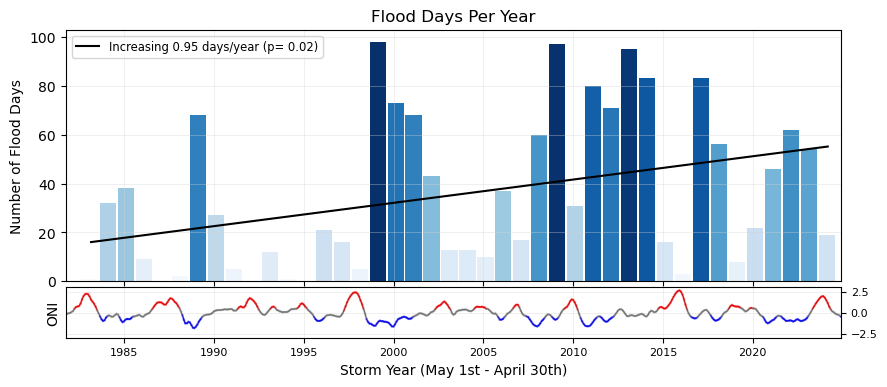

In [21]:
# Create two subplots sharing the same x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 4),  sharex=True, gridspec_kw={"height_ratios": [5, 1],"hspace": 0.04, }
)
# Plot the bar chart for flood days on the first subplot
x_values = flood_days_per_year['year_storm']  # Assuming this is already aligned to storm years
x_values_offset = x_values - 4/12  # Shift x-values to align with the storm years
y_values = flood_days_per_year['flood_days_count']
bar_width = 0.9

flooding_colors = sns.color_palette("Blues", as_cmap=True)
norm = Normalize(vmin=min(y_values), vmax=max(y_values))
colors = flooding_colors(norm(y_values))

ax1.bar(x_values_offset, y_values, width=bar_width, color=colors, align='edge')

ax1.set_ylabel('Number of Flood Days')
ax1.set_title('Flood Days Per Year')
ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)

# Plot the ONI index on the second subplot
oni['year_float'] = oni.index.year + (oni.index.month - 1) / 12

# shifted x-axis to align with flood days histogram storm years

# x_offset = flood_days_per_year['year_storm'].min() + 4/12

ax2.plot(oni['year_float'], oni['ONI'], color='k',linewidth=0.5, label='ONI')
ax2.set_ylabel('ONI')
ax2.set_xlabel('Storm Year (May 1st - April 30th)')
ax2.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.set_ylim(-3, 3)

ax1.set_xlim(x_values_offset.min()-bar_width, x_values.max()+bar_width)
ax2.set_xlim(x_values_offset.min()-bar_width, x_values.max()+bar_width)

# Define thresholds for ONI values
el_nino_threshold = 0.5
la_nina_threshold = -0.5

# Loop through the data to plot segments with different colors
for i in range(len(oni) - 1):
    x = oni['year_float'].iloc[i:i+2]
    y = oni['ONI'].iloc[i:i+2]
    
    if y.mean() >= el_nino_threshold:
        color = 'red'
    elif y.mean() <= la_nina_threshold:
        color = 'blue'
    else:
        color = 'gray'
    
    ax2.plot(x, y, color=color, linewidth=1.5, alpha=0.5)




# put y-axis labels on the right side for ax2
ax2.yaxis.tick_right()

# set font size for tick labels
ax2.tick_params(axis='both', which='major', labelsize=8)

# Add the trendline to the first subplot

# Aggregating data and fitting the trendline

slope, intercept, r_value, p_value, std_err = stats.linregress(x_values_offset+0.5, y_values)
trendDays = intercept + slope * (x_values_offset+0.5)
trendLabel = 'Increasing {:.2f} days/year (p= {:.2f})'.format(slope,p_value)

if p_value < 0.05:
    linestyleTrend = '-'
else:
    linestyleTrend = '--'

ax1.plot(x_values_offset+0.5, trendDays, color='black', linestyle=linestyleTrend, label=trendLabel)

# Adding the legend
ax1.legend(loc='upper left', fontsize='small')

# # save the trendline values
glue("day_per_year_trend",slope,display=False)
glue("p_value_days",p_value,display=False)

# # save the figure
glue("fig-threshold_counts_enso", fig, display=False)

# save to output directory
fig.savefig(output_dir / "SL_FloodFrequency_threshold_counts_days.png", dpi=300, bbox_inches='tight')



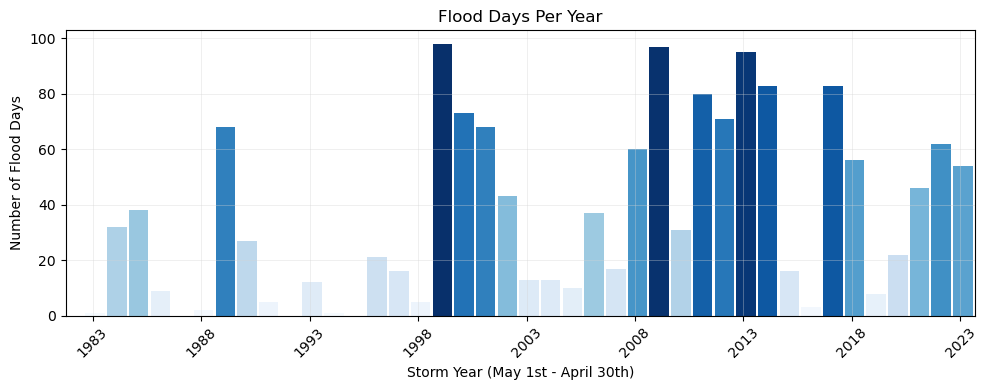

In [22]:
x_values = flood_days_per_year['year_storm']  # Assuming this is already aligned to storm years
y_values = flood_days_per_year['flood_days_count']
bar_width = 0.9  # Adjust the width of the bars

# Offset x-values by 4/12 (4 months = May start)
x_values_offset = x_values - 4/12

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x_values_offset, y_values, width=bar_width, color=colors, align='edge')

# Add gridlines for better readability
ax.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)

# Add labels and title
ax.set_xlabel('Storm Year (May 1st - April 30th)')
ax.set_ylabel('Number of Flood Days')
ax.set_title('Flood Days Per Year')

# Adjust x-ticks to match storm years
ax.set_xticks(x_values[::5])  # Use storm years for ticks, spaced every 5 years
ax.set_xticklabels(x_values[::5].astype(int), rotation=45)

# Set x-limits to ensure all bars are visible
ax.set_xlim(x_values_offset.min() - bar_width, x_values_offset.max())

# Show the plot
plt.tight_layout()
plt.show()

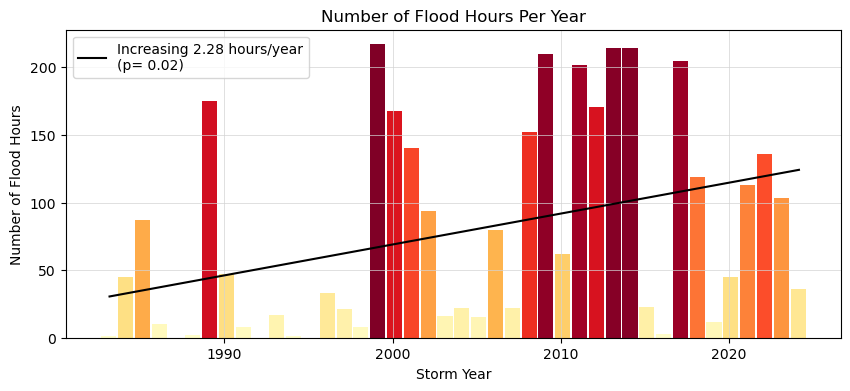

In [23]:

# Adjusting the heatmap palette to improve readability
from matplotlib.colors import Normalize

adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)



# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 4))
# Adding a light gray grid
ax.grid(color='lightgray', linestyle='-', linewidth=0.5)

y_values = flood_hours_per_year['flood_hours_count']
x_values = flood_hours_per_year['year_storm']
bar_width = 0.9
norm = Normalize(vmin=min(y_values), vmax=max(y_values))
colors = adjusted_heatmap_palette(norm(y_values))

# Offset x-values by 4/12 (4 months = May start)
x_values_offset = x_values - 4/12

ax.bar(x_values_offset, y_values, width=bar_width, color=colors, align='edge')

ax.set_xlabel('Storm Year')
ax.set_ylabel('Number of Flood Hours')
ax.set_title('Number of Flood Hours Per Year')

slope, intercept, r_value, p_value, std_err = stats.linregress(x_values_offset+0.5, y_values)
trendHours = intercept + slope * (x_values_offset+0.5)
trendLabel = 'Increasing {:.2f} hours/year\n(p= {:.2f})'.format(slope, p_value)

if p_value < 0.05:
    linestyleTrend = '-'
else:
    linestyleTrend = '--'

ax.plot(x_values_offset+0.5, trendHours, color='black', linestyle=linestyleTrend, label=trendLabel)

# Adding the legend
ax.legend(loc='upper left', fontsize='small')

# # save the trendline values
# glue("hours_per_year_trend",slope,display=False)
# glue("p_value_hours",p_value,display=False)

# Adding the legend
ax.legend(loc='upper left')

# glue("duration_fig", fig, display=False)

# save the figure
fig.savefig(output_dir / 'SL_FloodFrequency_threshold_counts_hours.png', bbox_inches='tight')

In [24]:
# Calculate the total number of days/hours exceeding the threshold
total_flood_days = flood_days_per_year['flood_days_count'].sum()
total_flood_hours = flood_hours_per_year['flood_hours_count'].sum()

# Calculate the average number of flood days and hours per year
average_flood_days_per_year = total_flood_days / len(flood_days_per_year)
average_flood_hours_per_year = flood_hours_per_year['flood_hours_count'].mean()

# Find the maximum number of flood days in a single year
max_flood_days = flood_days_per_year['flood_days_count'].max()
max_flood_days_year = flood_days_per_year.loc[flood_days_per_year['flood_days_count'].idxmax(), 'year_storm']

# Find the maximum number of flood hours in a single year
max_flood_hours = flood_hours_per_year['flood_hours_count'].max()
max_flood_hours_year = flood_hours_per_year.loc[flood_hours_per_year['flood_hours_count'].idxmax(), 'year_storm']

# calculate the absolute percent change over the entire period using the first and last part of the trend
percent_change_days = (trendDays.iloc[-1]-trendDays.iloc[0])/trendDays.iloc[0]*100
percent_change_hours = (trendHours.iloc[-1]-trendHours.iloc[0])/trendHours.iloc[0]*100

In [25]:
# Create a dataframe for statistics
summary_stats = [
    ('Total Flood Days', int(total_flood_days)),
    ('Average Flood Days per Year', int(average_flood_days_per_year)),
    ('Max Flood Days in a Single Year', int(max_flood_days)),
    ('Year of Max Flood Days', int(max_flood_days_year)),
    ('Total Flood Hours', int(total_flood_hours)),
    ('Average Flood Hours per Year', int(average_flood_hours_per_year)),
    ('Max Flood Hours in a Single Year', int(max_flood_hours)),
    ('Year of Max Flood Hours', int(max_flood_hours_year)),
    ('Percent Change in Flood Days', int(percent_change_days)),
    ('Percent Change in Flood Hours', int(percent_change_hours))
]

# Convert the list of tuples to a pandas DataFrame
summary_stats_df = pd.DataFrame(summary_stats, columns=['Statistic', 'Value'])

# Display the DataFrame
summary_stats_df

,Statistic,Value
0,Total Flood Days,1495
1,Average Flood Days per Year,35
2,Max Flood Days in a Single Year,98
3,Year of Max Flood Days,1999
4,Total Flood Hours,3249
5,Average Flood Hours per Year,77
6,Max Flood Hours in a Single Year,217
7,Year of Max Flood Hours,1999
8,Percent Change in Flood Days,243
9,Percent Change in Flood Hours,307


In [26]:
import calendar
# Make a dataframe with years as rows and months as columns
df = SL_daily_max.to_dataframe().reset_index()
df['flood_day'] = df['sea_level_mhhw'] > threshold*10

# keep only the flood day and time columns
df = df[['time', 'flood_day']]

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

# adjust for storm year
df.loc[df['month'] > 4, 'year'] = df.loc[df['month'] > 4, 'year'] + 1

# drop original time column
df = df.drop(columns=['time'])

# sum the number of flood days in each month for each storm year
df = df.groupby(['year', 'month']).sum()

# pivot the table
df = df.pivot_table(index='year', columns='month', values='flood_day')

# remove first and last rows (partial years)
# df = df.iloc[1:-1]

# rename year to Storm Year
df.index.name = 'Storm Year'

#define reordered months (for storm year, May to April)
month_order = [5,6,7,8,9,10,11,12,1,2,3,4]
month_names = [calendar.month_abbr[i] for i in month_order]
# rename months to month names
df = df[month_order]
df.columns = month_names

# add a column for the total number of flood days in each year
df['Annual'] = df.sum(axis=1)



# add a row for the total number of flood days in each month, normalized the total flood days (last row, last column)
df.loc['Monthly Total (%)'] = df.sum()
df.loc['Monthly Total (%)'] = 100*df.loc['Monthly Total (%)']/df.loc['Monthly Total (%)', 'Annual']

station_name = SL_daily_max['station_name'].values[0].decode('utf-8') +', ' + SL_daily_max['station_country'].values[0].decode('utf-8')

tableTitle = station_name + ': Days Exceeding ' + str(threshold) + ' cm above MHHW'
# Apply background gradient and add a title with larger text
styled_df = df.style.background_gradient(
    cmap='Purples', axis=None, subset=(df.index[:-1], df.columns[:-1])
).format("{:.0f}").background_gradient(
    cmap='Grays', axis=None, subset=(df.index[-1], df.columns[:-1])
).format("{:.0f}").set_caption(tableTitle).set_table_styles([
    {
        'selector': 'caption',
        'props': [('font-size', '16px'), ('margin-bottom', '10px')]
    }
])

styled_df


,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,Annual
Storm Year,,,,,,,,,,,,,
1983,0,0,0,0,0,0,0,0,0,1,0,0,1
1984,1,5,5,4,3,2,1,0,2,3,1,5,32
1985,5,0,4,9,6,3,4,0,0,0,3,4,38
1986,3,2,0,0,2,2,0,0,0,0,0,0,9
1987,0,0,0,0,0,0,0,0,0,0,0,0,0
1988,0,1,0,1,0,0,0,0,0,0,0,0,2
1989,0,0,4,8,6,7,4,3,17,7,7,5,68
1990,4,0,2,6,5,4,4,0,0,0,0,2,27
1991,3,1,0,0,1,0,0,0,0,0,0,0,5


In [27]:
#make a pretty pdf of the table with great_tables
from great_tables import GT,html

dfGT = df.copy()
dfGT['Storm Year'] = df.index

# put the year column first
cols = dfGT.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfGT = dfGT[cols]
dfGT.reset_index(drop=True, inplace=True)


# Create a GreatTable object
table = (GT(dfGT)
.fmt_number(columns=calendar.month_abbr[1:13], decimals=0)
.fmt_number(columns=['Annual'], decimals=0)
.tab_header(title = 'Days Exceeding 30 cm above MHHW', subtitle = station_name)
.data_color(domain = [0,20],
            columns=calendar.month_abbr[1:13],
            rows = list(range(len(dfGT)-1)),
            palette=["white", "lightblue"])
.data_color(domain = [0,20],
            columns=calendar.month_abbr[1:13],
            rows = [-1],
            palette=["white", "purple"])
.opt_table_outline(style='solid', width='3px', color='white')
)

# save table as png
tableName = station_name + '_flood_days_intra_annual.png'
savePath = os.path.join(output_dir, tableName)

# set size of table

# replace any commas or spaces with underscores
# savePath = savePath.replace(' ', '_')
table.save(savePath)

# Load Image
from IPython.display import Image
imgTable = Image(filename=savePath)

# Glue the image with a name
glue("imgTable", imgTable, display=False)


In [28]:
# Define the decades for analysis
decades = [(1983, 1993), (1993, 2003), (2003, 2013), (2013, 2023)]

# Initialize lists to store results
total_flood_days_list = []
average_flood_days_per_year_list = []
percent_increase_days_per_year_list = [0]  # First decade has no previous data for comparison

# Calculate statistics for each decade
for i, (start_year, end_year) in enumerate(decades):
    # Filter the dataframe for the current decade
    flood_days_decade = flood_days_per_year[(flood_days_per_year['year_storm'] >= start_year) & (flood_days_per_year['year_storm'] <= end_year)]
    sum_flood_days_decade = flood_days_decade['flood_days_count'].sum()
    avg_flood_days_decade = sum_flood_days_decade / len(flood_days_decade)
    
    # Append results to lists
    total_flood_days_list.append(sum_flood_days_decade)
    average_flood_days_per_year_list.append(np.round(avg_flood_days_decade,0))
    
    # Calculate percent increase for subsequent decades
    if i > 0:
        prev_avg_flood_days = average_flood_days_per_year_list[0]
        percent_increase = np.round((avg_flood_days_decade - prev_avg_flood_days) / prev_avg_flood_days * 100, 1)
        percent_increase_days_per_year_list.append(percent_increase)

# Create a dataframe for decadal statistics
decadal_stats = pd.DataFrame({
    'decade': ['1983-1993', '1993-2003', '2003-2013', '2013-2023'],
    'total_flood_days': total_flood_days_list,
    'average_flood_days_per_year': average_flood_days_per_year_list,
    'percent_increase_days_per_year': percent_increase_days_per_year_list
})

decadal_stats


,decade,total_flood_days,average_flood_days_per_year,percent_increase_days_per_year
0,1983-1993,194,18.0,0.0
1,1993-2003,350,32.0,76.8
2,2003-2013,524,48.0,164.6
3,2013-2023,528,48.0,166.7


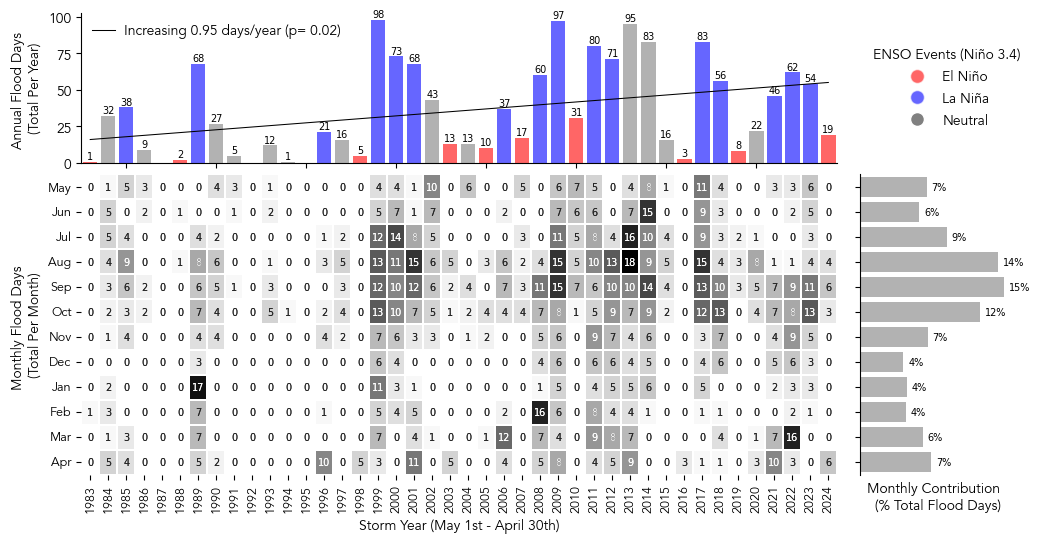

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Create a figure and shared axis layout
fig, axs = plt.subplots(2,2,figsize=(12,6), gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05, "width_ratios":[5,1], "wspace": 0.05})

# put stuff in the figure
# Create heatmap on the left
sns.heatmap(df.iloc[:-1, :-1].T, cmap="Blues", annot=True, fmt=".0f", linewidths=0.2,
            ax=axs[1,0],cbar=False, annot_kws={"size": 7})

# heatmap
sns.heatmap(df.iloc[:-1, :-1].T, cmap="Grays", annot=True, fmt=".0f", linewidths=0.2, 
            ax=axs[1,0],cbar=False, annot_kws={"size": 7})
axs[1,0].set_ylabel("Monthly Flood Days \n(Total Per Month)")
axs[1,0].set_xlabel("Storm Year (May 1st - April 30th)")
axs[1,0].tick_params(axis='y', labelsize=9)
axs[1,0].tick_params(axis='x', labelsize=9)

# map oni_year to colors using enso (we will keep this for now for possible future use)
# oni_colors = ['red' if val > 0.5 else 'blue' if val < -0.5 else 'gray' for val in flood_days_per_year['ONI']]

# color by enso_event
enso_colors = ['red' if val == 'El Niño' else 'blue' if val == 'La Niña' else 'gray' for val in flood_days_per_year['event']]



# yearly totals
ax2 = axs[0,0]
# set ax2 x-axis to be the same as ax1
bars = ax2.bar(df.index[0:-1], df["Annual"][0:-1], color=enso_colors, alpha=0.6, label="Annual Flood Days")
ax2.set_xlim(df.index[0]-0.5, df.index[-2]+0.5)
ax2.set_ylabel("Annual Flood Days \n(Total Per Year)")

# Add annotations to bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{int(height)}", 
                 ha='center', va='bottom', fontsize=7, color="black")

# remove top and right boudaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)



# bar plot of monthly totals
ax3 = axs[1,1]
barMonth = ax3.barh(range(1, 13), df.iloc[-1, :-1][::-1], color="gray", alpha=0.6, label="Mean Yearly Flood Days")
ax3.set_yticks(range(1, 13))
ax3.set_ylim(0.5, 12.5)
# remove y-axis labels
ax3.set_yticklabels([])

#remove x-axis ticks and labels
ax3.set_xticks([])

ax3.set_xlabel("Monthly Contribution \n (% Total Flood Days)")

#remove top and right boudaries
for spine in ax3.spines.values():
    spine.set_visible(False)

ax3.spines['left'].set_visible(True)


# add annotations to bars
for bar in barMonth:
    width = bar.get_width()
    if width > 0:
        ax3.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{int(width)}%", 
                 ha='left', va='center', fontsize=7, color="black")
        
# ax[0,1] defines the oni_color legend
ax4 = axs[0,1]
ax4.axis('off')
# create a legend for the oni_colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='El Niño', markerfacecolor='red', markersize=10, alpha=0.6),
                   plt.Line2D([0], [0], marker='o', color='w', label='La Niña', markerfacecolor='blue', markersize=10, alpha=0.6),
                   plt.Line2D([0], [0], marker='o', color='w', label='Neutral', markerfacecolor='gray', markersize=10)]
legend = ax4.legend(handles=legend_elements, loc='center left', title='ENSO Events (Niño 3.4)', frameon=False)


legend_title = legend.get_title()
legend_title.set_fontsize('10')
legend_title.set_fontname('Avenir')
legend_texts = legend.get_texts()
for text in legend_texts:
    text.set_fontname('Avenir')
    text.set_fontsize('10')


# add trendline to the yearly totals
x = df.index[0:-1].astype(int).values
y = df["Annual"][0:-1].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
trendDays = intercept + slope * x
trendLabel = 'Increasing {:.2f} days/year (p= {:.2f})'.format(slope,p_value)

if p_value < 0.05:
    linestyleTrend = '-'
else:
    linestyleTrend = '--'

ax2.plot(x, trendDays, color='black', linestyle=linestyleTrend, label=trendLabel, linewidth=0.75)

# add another legend for the trendline
# Add a new legend only for the trendline
legendTrend = ax2.legend([plt.Line2D([0], [0], color='black', linestyle=linestyleTrend, linewidth=0.75)],
           [trendLabel], loc='upper left', fontsize='small', frameon=False)
legendTrend_texts = legendTrend.get_texts()
for text in legendTrend_texts:
    text.set_fontname('Avenir')
    text.set_fontsize('10')




# set all fonts in the figure to Avenir
# Iterate over all axes in the figure
for ax in axs.flat:
    # Change font for title, axis labels, and tick labels
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontname('Avenir')


#save the figure
fig.savefig(output_dir / 'SL_FloodFrequency_threshold_counts_heatmap.png', bbox_inches='tight')
plt.savefig(op.join(path_figs, 'F11_Minor_flood_matrix.png'), dpi=300, bbox_inches='tight')


In [30]:
# make a function for adding the arrows
def add_arrow(ax, lat,lon,percent_change,crs, vmin, vmax):
# make colormap of percent change
    adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)

    # Prepare data for quiver plot
    U = np.zeros_like(lon)  # Dummy U component (no horizontal movement)
    V = percent_change/100   # V component scaled by percent change
    arrow_scale = 5  # Adjust as necessary for arrow size
    arrow_width = 0.01  # Adjust for desired arrow thickness

    # Quiver plot
    q = ax.quiver(lon,lat, U, V, transform=crs, scale=arrow_scale,
              color=adjusted_heatmap_palette(percent_change / vmax), 
              cmap=adjusted_heatmap_palette, clim=(vmin, vmax), width=arrow_width)

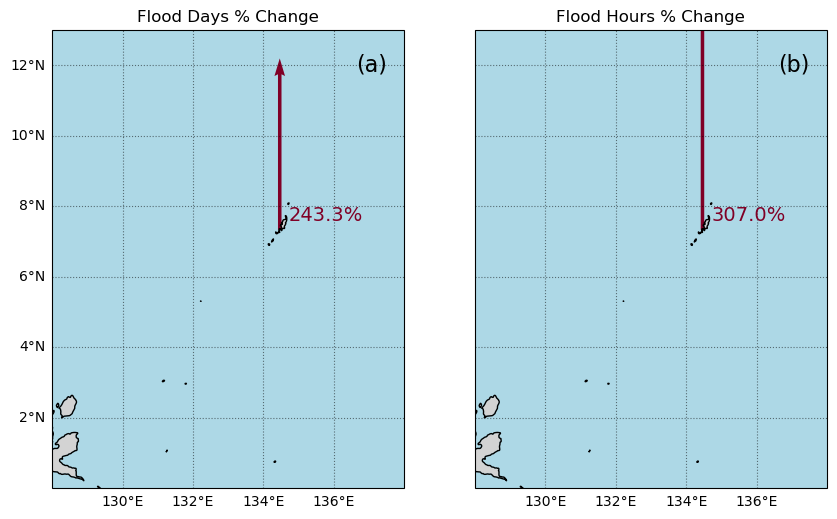

In [31]:
xlims = [128, 138]
ylims = [0, 13]
vmin, vmax = 0,100

# fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': crs})


for i, ax in enumerate(axs):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    ax.coastlines()

    # Fill in water
    ax.add_feature(cfeature.LAND, color='lightgrey')
    # add a) b) labels
    ax.text(0.95, 0.95, f'({chr(97 + i)})', 
            horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,
            fontsize=16)
    
    ax.add_feature(cfeature.OCEAN, color='lightblue')

    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

    if ax == axs[1]:
        gl.left_labels = False

add_arrow(axs[0], rsl['lat'], rsl['lon'], percent_change_days, crs, vmin, vmax)
add_arrow(axs[1], rsl['lat'], rsl['lon'], percent_change_hours, crs, vmin, vmax)

# Put titles on the subplots
axs[0].set_title('Flood Days % Change')
axs[1].set_title('Flood Hours % Change')

# Add text for percent change
for i in range(len(rsl['lon'])):
    axs[0].text(rsl['lon'][i] + 0.25, rsl['lat'][i] + 0.25, '{:.1f}%'.format(percent_change_days), fontsize=14,
                color=adjusted_heatmap_palette(percent_change_days / vmax))
    axs[1].text(rsl['lon'][i] + 0.25, rsl['lat'][i] + 0.25, '{:.1f}%'.format(percent_change_hours), fontsize=14,
                color=adjusted_heatmap_palette(percent_change_hours / vmax))


# glue("mag_fig", fig, display=False)

# Save the figure
output_file_path = output_dir / 'SL_FloodFrequency_map.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')
